In [1]:
import pandas as pd
import numpy as np

In [2]:
journal_entries = pd.read_csv('./Data/journal_entries.csv')
phys_cycles = pd.read_csv('./Data/physiological_cycles.csv')
sleeps = pd.read_csv('./Data/sleeps.csv')
workouts = pd.read_csv('./Data/workouts.csv')

journal_pivot = journal_entries.pivot_table(
    index='Cycle start time',
    columns='Question text',
    values='Answered yes',
    aggfunc='first'
).reset_index()

journal_pivot.columns.name = None
journal_pivot.columns = ['Cycle start time'] + [
    col.lower()
       .replace(' ', '_')
       .replace('?', '')
       .replace('(', '')
       .replace(')', '')
       .replace('-', '_') for col in journal_pivot.columns[1:]
]


sleeps_cleaned = sleeps.drop(columns=['Cycle end time', 'Cycle timezone'])
workouts_cleaned = workouts.drop(columns=['Cycle end time', 'Cycle timezone'])

# Merge physiological data and sleep
phys_sleep = pd.merge(phys_cycles, sleeps_cleaned, on='Cycle start time', how='left')

# Merge with workouts
phys_sleep_workout = pd.merge(phys_sleep, workouts_cleaned, on='Cycle start time', how='left')

# Merge with journal data
final_df = pd.merge(phys_sleep_workout, journal_pivot, on='Cycle start time', how='left')

# Convert datetime fields
final_df['Cycle start time'] = pd.to_datetime(final_df['Cycle start time'])

# Optional: Sort chronologically
final_df = final_df.sort_values('Cycle start time').reset_index(drop=True)

# Save or return for use
final_df.to_csv('whoop_preprocessed.csv', index=False)

# Display preview
print(final_df.head())


     Cycle start time       Cycle end time Cycle timezone  Recovery score %  \
0 2024-09-22 00:00:00  2024-09-22 20:44:13      UTC-05:00               NaN   
1 2024-09-22 20:44:13  2024-09-23 21:31:35      UTC-05:00              59.0   
2 2024-09-23 21:31:35  2024-09-25 00:11:03      UTC-05:00              62.0   
3 2024-09-23 21:31:35  2024-09-25 00:11:03      UTC-05:00              62.0   
4 2024-09-25 00:11:03  2024-09-25 21:52:51      UTC-05:00              64.0   

   Resting heart rate (bpm)  Heart rate variability (ms)  Skin temp (celsius)  \
0                       NaN                          NaN                  NaN   
1                      57.0                         67.0                33.41   
2                      57.0                         64.0                33.40   
3                      57.0                         64.0                33.40   
4                      60.0                         67.0                33.30   

   Blood oxygen %  Day Strain  Energy 

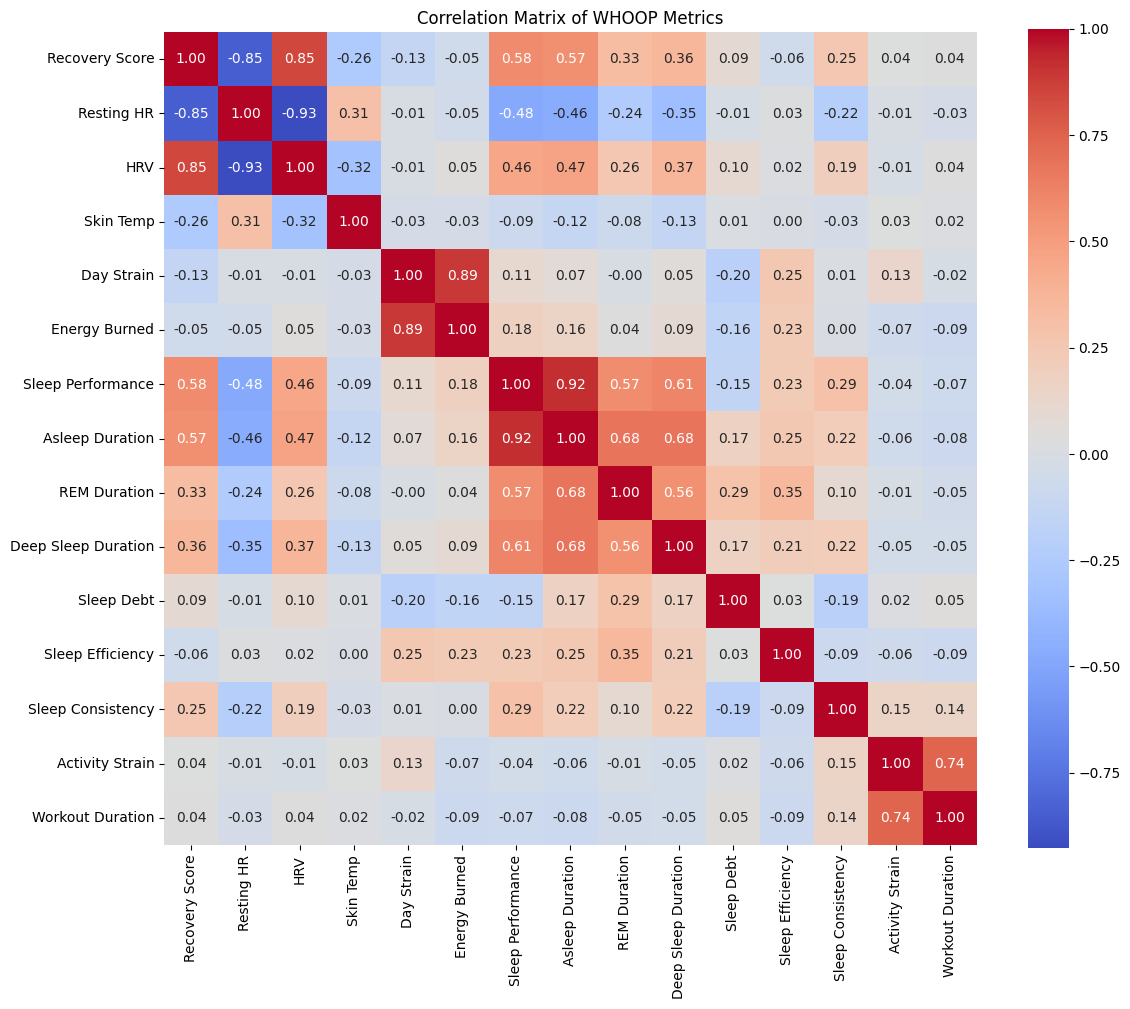

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

eda_df = final_df[[
    'Cycle start time',
    'Recovery score %',
    'Resting heart rate (bpm)',
    'Heart rate variability (ms)',
    'Skin temp (celsius)',
    'Day Strain',
    'Energy burned (cal)_x',
    'Sleep performance %_x',
    'Asleep duration (min)_x',
    'REM duration (min)_x',
    'Deep (SWS) duration (min)_x',
    'Sleep debt (min)_x',
    'Sleep efficiency %_x',
    'Sleep consistency %_x',
    'Activity Strain',
    'Duration (min)'
]].copy()

# Drop rows where all selected metrics are NaN
eda_df = eda_df.dropna(how='all')

# Rename columns for plotting
eda_df.columns = [
    'Cycle start time',
    'Recovery Score',
    'Resting HR',
    'HRV',
    'Skin Temp',
    'Day Strain',
    'Energy Burned',
    'Sleep Performance',
    'Asleep Duration',
    'REM Duration',
    'Deep Sleep Duration',
    'Sleep Debt',
    'Sleep Efficiency',
    'Sleep Consistency',
    'Activity Strain',
    'Workout Duration'
]

# Compute correlation matrix
corr = eda_df.drop(columns=['Cycle start time']).corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of WHOOP Metrics")
plt.tight_layout()
plt.show()


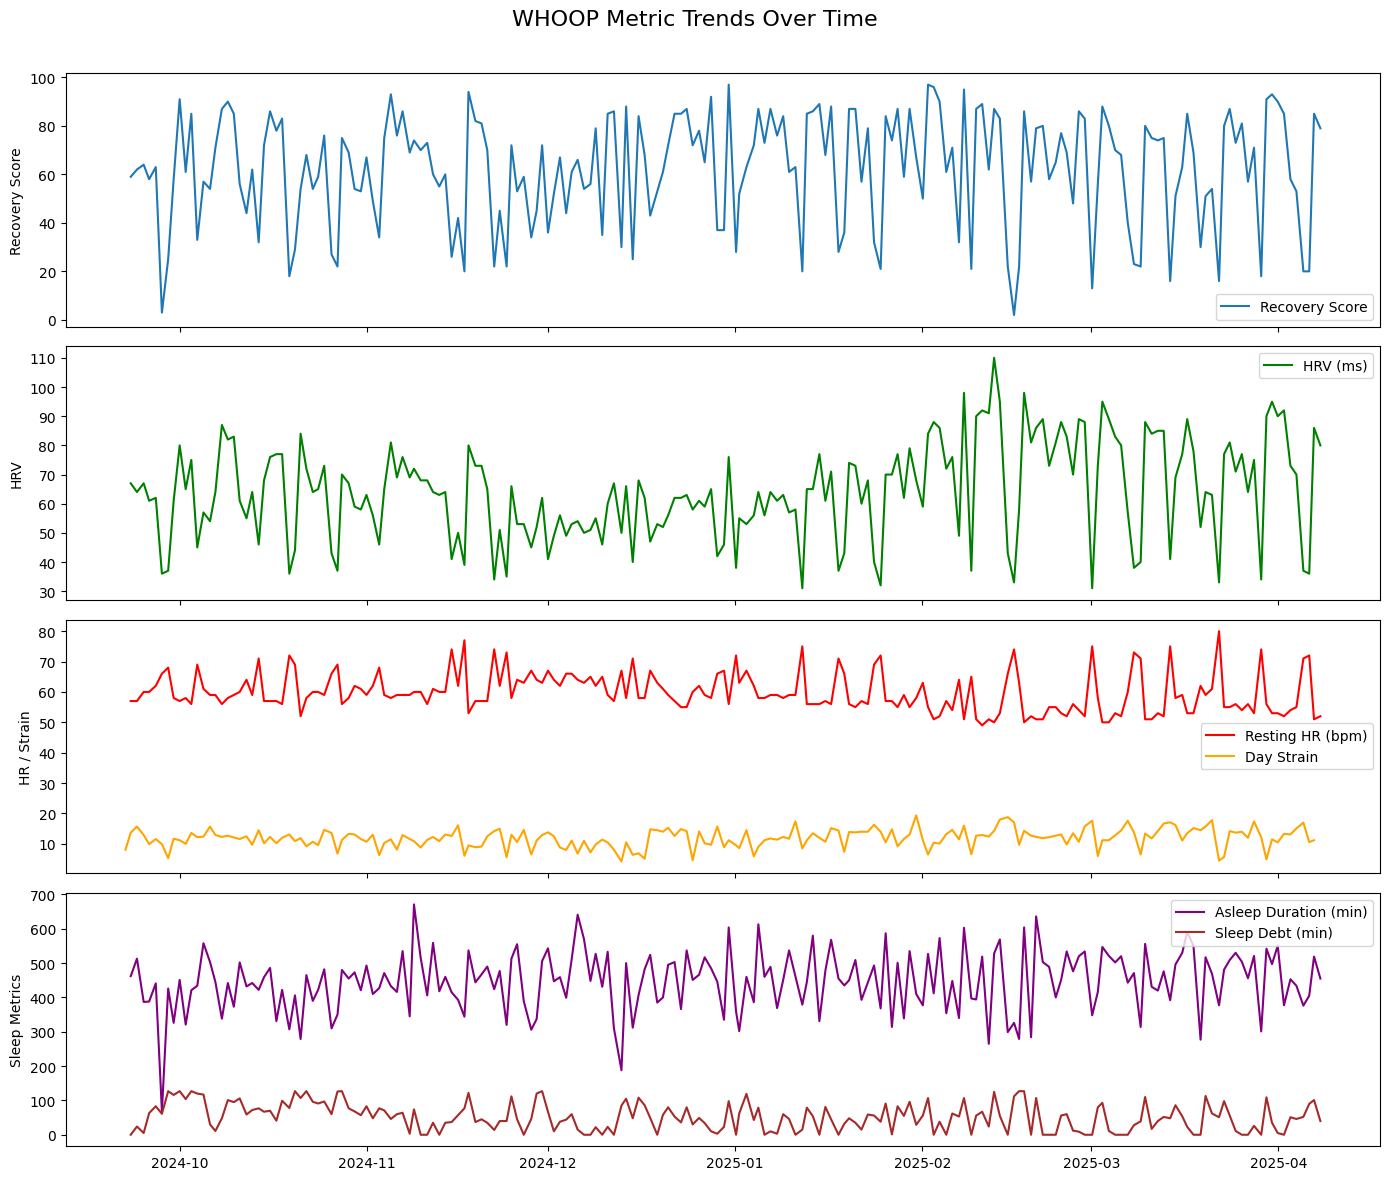

In [4]:
# Set datetime index for time series plotting
eda_df['Cycle start time'] = pd.to_datetime(eda_df['Cycle start time'])
eda_df = eda_df.sort_values('Cycle start time')
eda_df.set_index('Cycle start time', inplace=True)

# Plot key trends over time
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Plot Recovery Score and HRV
axs[0].plot(eda_df.index, eda_df['Recovery Score'], label='Recovery Score')
axs[0].set_ylabel('Recovery Score')
axs[0].legend()

axs[1].plot(eda_df.index, eda_df['HRV'], label='HRV (ms)', color='green')
axs[1].set_ylabel('HRV')
axs[1].legend()

# Plot Resting HR and Day Strain
axs[2].plot(eda_df.index, eda_df['Resting HR'], label='Resting HR (bpm)', color='red')
axs[2].plot(eda_df.index, eda_df['Day Strain'], label='Day Strain', color='orange')
axs[2].set_ylabel('HR / Strain')
axs[2].legend()

# Plot Sleep-related metrics
axs[3].plot(eda_df.index, eda_df['Asleep Duration'], label='Asleep Duration (min)', color='purple')
axs[3].plot(eda_df.index, eda_df['Sleep Debt'], label='Sleep Debt (min)', color='brown')
axs[3].set_ylabel('Sleep Metrics')
axs[3].legend()

plt.suptitle("WHOOP Metric Trends Over Time", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [5]:
import pandas as pd

# === Load Data ===
journal_entries = pd.read_csv('./Data/journal_entries.csv')
phys_cycles = pd.read_csv('./Data/physiological_cycles.csv')
sleeps = pd.read_csv('./Data/sleeps.csv')
workouts = pd.read_csv('./Data/workouts.csv')

# === Pivot Journal Entries ===
journal_pivot = journal_entries.pivot_table(
    index='Cycle start time',
    columns='Question text',
    values='Answered yes',
    aggfunc='first'
).reset_index()

# Clean column names
journal_pivot.columns.name = None
journal_pivot.columns = ['Cycle start time'] + [
    col.lower().replace(' ', '_').replace('?', '').replace('(', '').replace(')', '').replace('-', '_')
    for col in journal_pivot.columns[1:]
]

# === Merge All Tables ===
sleeps_cleaned = sleeps.drop(columns=['Cycle end time', 'Cycle timezone'])
workouts_cleaned = workouts.drop(columns=['Cycle end time', 'Cycle timezone'])
merged = pd.merge(phys_cycles, sleeps_cleaned, on='Cycle start time', how='left')
merged = pd.merge(merged, workouts_cleaned, on='Cycle start time', how='left')
merged = pd.merge(merged, journal_pivot, on='Cycle start time', how='left')
merged['Cycle start time'] = pd.to_datetime(merged['Cycle start time'])
merged = merged.sort_values('Cycle start time').reset_index(drop=True)

# === Feature Engineering ===
# Set time index
df = merged.set_index('Cycle start time').copy()

# Rename for convenience
df.rename(columns={
    'Recovery score %': 'Recovery Score',
    'Resting heart rate (bpm)': 'Resting HR',
    'Heart rate variability (ms)': 'HRV',
    'Skin temp (celsius)': 'Skin Temp',
    'Day Strain': 'Day Strain',
    'Energy burned (cal)_x': 'Energy Burned',
    'Sleep performance %_x': 'Sleep Performance',
    'Asleep duration (min)_x': 'Asleep Duration',
    'REM duration (min)_x': 'REM Duration',
    'Deep (SWS) duration (min)_x': 'Deep Sleep Duration',
    'Sleep debt (min)_x': 'Sleep Debt',
    'Sleep efficiency %_x': 'Sleep Efficiency',
    'Sleep consistency %_x': 'Sleep Consistency',
    'Activity Strain': 'Activity Strain',
    'Duration (min)': 'Workout Duration'
}, inplace=True)

# Compute derived features
df['REM_ratio'] = df['REM Duration'] / df['Asleep Duration']
df['Deep_ratio'] = df['Deep Sleep Duration'] / df['Asleep Duration']
df['HRV_RHR_ratio'] = df['HRV'] / df['Resting HR']
df['day_of_week'] = df.index.dayofweek
df['week_of_year'] = df.index.isocalendar().week
df['Recovery_prev_day'] = df['Recovery Score'].shift(1)
df['HRV_prev_day'] = df['HRV'].shift(1)
df['Strain_prev_day'] = df['Day Strain'].shift(1)
df['Recovery_rolling3'] = df['Recovery Score'].rolling(window=3).mean()
df['HRV_rolling3'] = df['HRV'].rolling(window=3).mean()
df['SleepDebt_rolling3'] = df['Sleep Debt'].rolling(window=3).mean()

# Convert journal inputs to numeric
journal_cols = [col for col in df.columns if col.startswith('have_any_') or col.startswith('eat_any_') or col.startswith('read_')]
df[journal_cols] = df[journal_cols].astype(float)

# Drop rows with missing values from shifts/rolls
df_clean = df.copy()

# Optional: Save to CSV
df_clean.to_csv('whoop_features_engineered.csv')

# Display sample
print(df_clean.head())


                          Cycle end time Cycle timezone  Recovery Score  \
Cycle start time                                                          
2024-09-22 00:00:00  2024-09-22 20:44:13      UTC-05:00             NaN   
2024-09-22 20:44:13  2024-09-23 21:31:35      UTC-05:00            59.0   
2024-09-23 21:31:35  2024-09-25 00:11:03      UTC-05:00            62.0   
2024-09-23 21:31:35  2024-09-25 00:11:03      UTC-05:00            62.0   
2024-09-25 00:11:03  2024-09-25 21:52:51      UTC-05:00            64.0   

                     Resting HR   HRV  Skin Temp  Blood oxygen %  Day Strain  \
Cycle start time                                                               
2024-09-22 00:00:00         NaN   NaN        NaN             NaN         8.1   
2024-09-22 20:44:13        57.0  67.0      33.41           97.06        13.7   
2024-09-23 21:31:35        57.0  64.0      33.40           96.25        15.7   
2024-09-23 21:31:35        57.0  64.0      33.40           96.25        15

In [6]:

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Re-extract only numeric columns from df_model safely
df_model = df_clean.copy()
df_model = df_model[df_model['Recovery Score'].notna()]

# Select numeric columns only
numeric_df = df_model.select_dtypes(include=[np.number])

# Separate features and target
X = numeric_df.drop(columns=['Recovery Score'])
y = numeric_df['Recovery Score']

# Ensure we have enough samples
if len(X) > 0:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    xgb.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = xgb.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb.feature_importances_
    }).sort_values(by='importance', ascending=False)

    feature_importance.head(10), rmse, r2
else:
    ("No valid numeric rows available for training.", 0, 0)


In [7]:
print(feature_importance)
print(r2)
print(rmse)

                                  feature  importance
0                              Resting HR    0.289011
1                                     HRV    0.143140
51                          HRV_RHR_ratio    0.133405
29                     Sleep debt (min)_y    0.103293
57                      Recovery_rolling3    0.044318
11                In bed duration (min)_x    0.023928
19                      Sleep Consistency    0.020825
16                     Sleep need (min)_x    0.017677
53                           week_of_year    0.016196
10                        Asleep Duration    0.015826
15                 Awake duration (min)_x    0.015189
59                     SleepDebt_rolling3    0.012121
52                            day_of_week    0.012060
9                Respiratory rate (rpm)_x    0.011810
8                       Sleep Performance    0.011576
58                           HRV_rolling3    0.011569
17                             Sleep Debt    0.011038
56                        St

In [8]:
# %pip install prophet

14:10:36 - cmdstanpy - INFO - Chain [1] start processing
14:10:36 - cmdstanpy - INFO - Chain [1] done processing


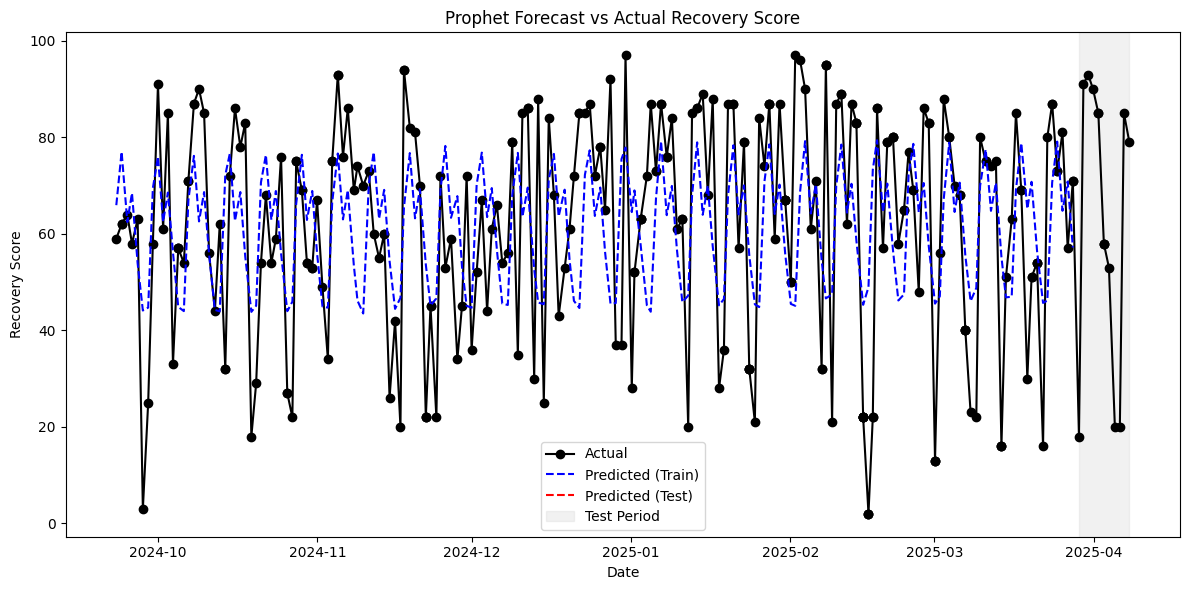

In [13]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Prepare Data
df_ts = df_clean.reset_index()[['Cycle start time', 'Recovery Score']].dropna()
df_ts = df_ts.rename(columns={'Cycle start time': 'ds', 'Recovery Score': 'y'})
df_ts = df_ts.sort_values('ds')

# Step 2: Split into train and test (e.g., last 14 days for test)
test_period = 14
train_df = df_ts.iloc[:-test_period]
test_df = df_ts.iloc[-test_period:]

# Step 3: Fit Prophet on training data
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(train_df)

# Step 4: Forecast over full date range (train + test)
future = model.make_future_dataframe(periods=test_period, freq='D')
forecast = model.predict(future)

# Step 5: Merge predictions with actuals
forecast_trim = forecast[['ds', 'yhat']].set_index('ds')
actuals = df_ts.set_index('ds')
comparison = actuals.join(forecast_trim, how='left')

# Step 6: Plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(comparison.index, comparison['y'], label='Actual', color='black', marker='o')

# Plot predicted values: train period
plt.plot(comparison.index[:-test_period], comparison['yhat'][:-test_period], 
         label='Predicted (Train)', linestyle='--', color='blue')

# Plot predicted values: test period
plt.plot(comparison.index[-test_period:], comparison['yhat'][-test_period:], 
         label='Predicted (Test)', linestyle='--', color='red')

# Highlight test period
plt.axvspan(test_df['ds'].min(), test_df['ds'].max(), color='lightgray', alpha=0.3, label='Test Period')

plt.title("Prophet Forecast vs Actual Recovery Score")
plt.xlabel("Date")
plt.ylabel("Recovery Score")
plt.legend()
plt.tight_layout()
plt.show()



In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. XGBoost Performance (from earlier model)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_r2 = r2_score(y_test, y_pred)

# 2. Prophet Performance
# Safely join actuals from test_df with Prophet predictions from forecast
merged_test = pd.merge(test_df, forecast[['ds', 'yhat']], on='ds', how='left')

# Drop rows with missing actuals or predictions
merged_test = merged_test.dropna(subset=['y', 'yhat'])

# Calculate RMSE and R² for Prophet
prophet_rmse = np.sqrt(mean_squared_error(merged_test['y'], merged_test['yhat']))
prophet_r2 = r2_score(merged_test['y'], merged_test['yhat'])

# 3. Comparison Results
print("🔍 Model Performance on Test Set:")
print(f"XGBoost  → RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")
print(f"Prophet  → RMSE: {prophet_rmse:.2f}, R²: {prophet_r2:.2f}")


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [15]:

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. XGBoost Performance
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_r2 = r2_score(y_test, y_pred)

# 2. Prophet Performance (on test period, drop NaNs just in case)
prophet_test = comparison.loc[test_df['ds']].dropna(subset=['y', 'yhat'])
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_test['yhat']))
prophet_r2 = r2_score(prophet_test['y'], prophet_test['yhat'])

# 3. Print side-by-side
print("🔍 Model Performance on Test Set:")
print(f"XGBoost  → RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")
print(f"Prophet  → RMSE: {prophet_rmse:.2f}, R²: {prophet_r2:.2f}")


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.